In [ ]:
# import library
import pandas as pd
import numpy as np
import re
import nltk
import string
import time
import psutil
import joblib
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

# Download NLTK wordnet
!pip install emoji
import emoji
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
stopwords_list = stopwords.words('indonesian')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


# Menggunakan Stemmer
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Membuat objek stemmer dari Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 25.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 14.5 MB/s eta 0:00:00


In [ ]:
data = 'dataset_skripsi_true_fix.xlsx'

dataset = pd.read_excel(data, sheet_name='data kotor')
dataset.head()

,sentiment,text,id,created_at
0,netral,"Salju terakhir di puncak Jaya, Papua, Indonesi...",1780148715233403306,2024-04-16 08:18:21
1,positif,Karena AP news baru rilis artikel soal kenaika...,1821276900486181283,2024-08-07 20:07:05
2,positif,Sejarah baru di Indonesia. Apakah ini adalah S...,1760537847441048063,2024-02-22 05:31:46
3,positif,Seluruh negara di dunia kini menghadapi tantan...,1708297321648451982,2023-10-01 01:46:34
4,positif,Sebuah kehormatan diundang sebagai pembicara d...,1591446551641354242,2022-11-12 15:03:20


In [ ]:
df_data = dataset.copy()
df_data['sentiment'].value_counts()

,count
sentiment,
positif,810
netral,775
negatif,691


In [ ]:
df_data = df_data.replace({'sentiment': {'negatif': '0', 'positif': '1', 'netral': '2'}})
df_data.head()

,sentiment,text,id,created_at
0,2,"Salju terakhir di puncak Jaya, Papua, Indonesi...",1780148715233403306,2024-04-16 08:18:21
1,1,Karena AP news baru rilis artikel soal kenaika...,1821276900486181283,2024-08-07 20:07:05
2,1,Sejarah baru di Indonesia. Apakah ini adalah S...,1760537847441048063,2024-02-22 05:31:46
3,1,Seluruh negara di dunia kini menghadapi tantan...,1708297321648451982,2023-10-01 01:46:34
4,1,Sebuah kehormatan diundang sebagai pembicara d...,1591446551641354242,2022-11-12 15:03:20


<ipython-input-5-e231cec24171>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_data, x='sentiment', palette="viridis")


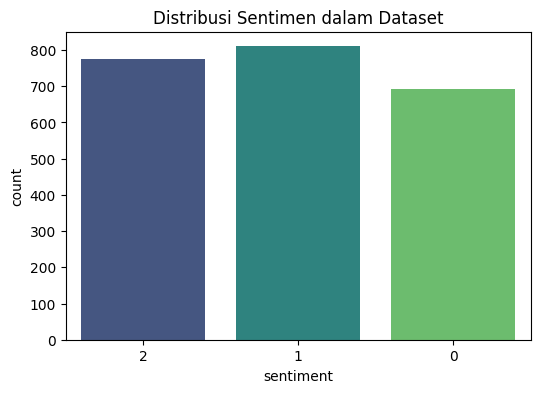

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. Distribusi Sentimen
plt.figure(figsize=(6, 4))
sns.countplot(data=df_data, x='sentiment', palette="viridis")
plt.title("Distribusi Sentimen dalam Dataset")
plt.show()

In [ ]:
# Pencatatan waktu mulai preprocessing
start_preprocess_time = time.time()

# Fungsi utama untuk pembersihan teks
def text_clean(text):
    # Menghapus emoji dari teks
    text = emoji.replace_emoji(text, replace="")
    # Menghapus mention, hashtag, dan URL
    text = re.sub(r"(@[A-Za-z0-9_]+)|(#\w+)|(\w+:\/\/\S+)", "", text)
    # Menghapus tag retweet
    text = re.sub(r'RT @\w+: ', '', text)
    # Menghapus tanda baca
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    # Menghapus teks dalam tanda kurung siku
    text = re.sub(r'\[.*?\]', '', text)
    # Menghapus karakter non-alfabet
    text = re.sub(r'\W', ' ', text)
    # Menghapus baris baru
    text = re.sub(r'\n', ' ', text)
    # Menghapus angka yang berdiri sendiri
    text = re.sub(r'\b\d+\b', '', text)
    # Menghapus spasi berlebih
    text = re.sub(' +', ' ', text)
    return text.strip()

# Fungsi untuk menghapus stopwords
extra_stopwords = ["yg", "amp"]
def remove_stopwords(text, stopwords=stopwords_list+extra_stopwords): # Add stopwords argument with default value
    # Memisahkan teks menjadi kata-kata
    words = text.split()
    # Menghapus kata yang ada dalam daftar stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords] # Use stopwords argument
    # Menggabungkan kembali kata-kata menjadi kalimat
    return ' '.join(filtered_words)

# Fungsi untuk melakukan lemmatization pada teks
# def lemmatize(text):
#     # Melakukan lemmatization untuk setiap kata dalam teks
#     return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Fungsi untuk melakukan stemming pada teks
def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

## Menerapkan Pra-pemrosesan Teks
print("Memulai pra-pemrosesan text...")
df_data['text'] = df_data['text'].apply(text_clean)
df_data['text'] = df_data['text'].apply(remove_stopwords) # Call remove_stopwords with only the text argument
# df_data['text'] = df_data['text'].apply(lemmatize)

# stemmed_texts = joblib.load("stemmed_texts.pkl")
# df_data['text'] = stemmed_texts
df_data['text'] = df_data['text'].apply(stem_text)

end_preprocess_time = time.time()
preprocessing_duration = end_preprocess_time - start_preprocess_time
print(f"Lama pra-pemrosesan teks: {round(preprocessing_duration, 2)} detik")
print("Pra-pemrosesan teks selesai.")

Memulai pra-pemrosesan text...
Lama pra-pemrosesan teks: 897.35 detik
Pra-pemrosesan teks selesai.


<ipython-input-7-0fbba3329c62>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


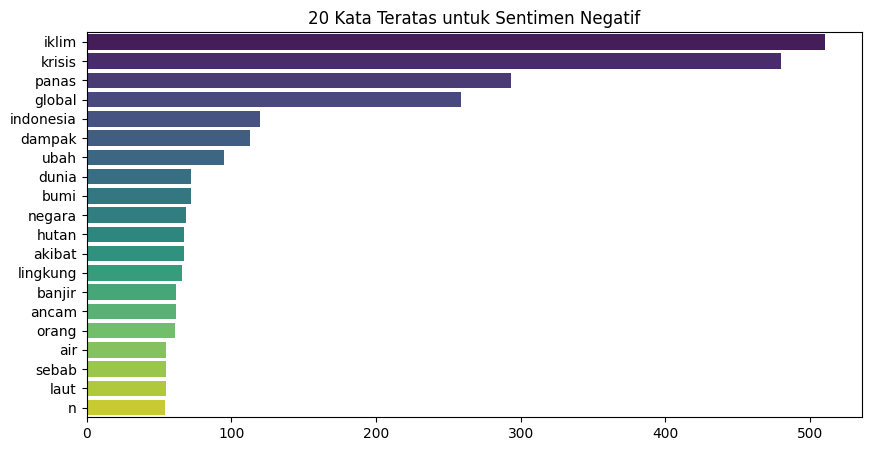

<ipython-input-7-0fbba3329c62>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


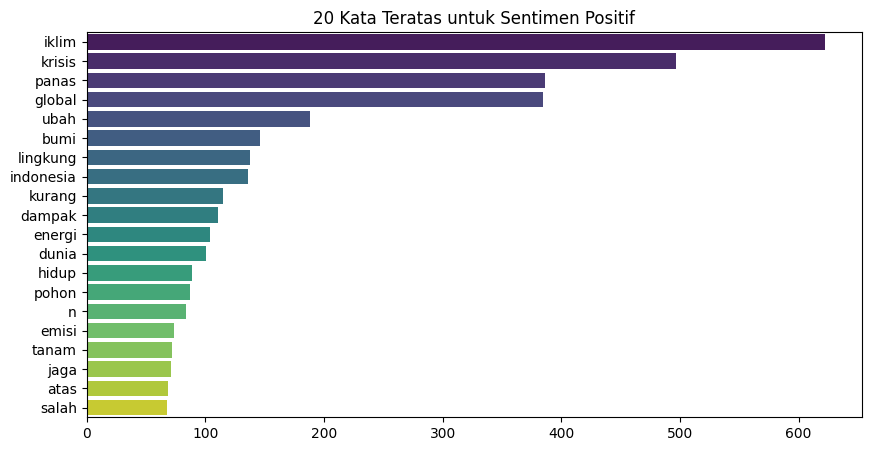

<ipython-input-7-0fbba3329c62>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


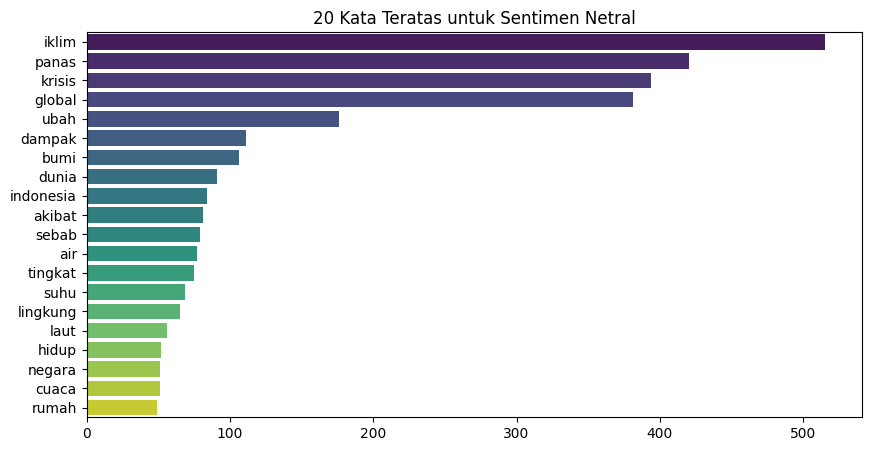

In [ ]:
# 2. Frekuensi Kata Teratas
from collections import Counter

def plot_top_words(data, sentiment_label, title):
    all_words = ' '.join([text for text in data[data['sentiment'] == sentiment_label]['text']])
    word_freq = Counter(all_words.split())
    common_words = word_freq.most_common(20)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(f"20 Kata Teratas untuk Sentimen {title}")
    plt.show()

# Panggil untuk setiap sentimen
plot_top_words(df_data, '0', "Negatif")
plot_top_words(df_data, '1', "Positif")
plot_top_words(df_data, '2', "Netral")

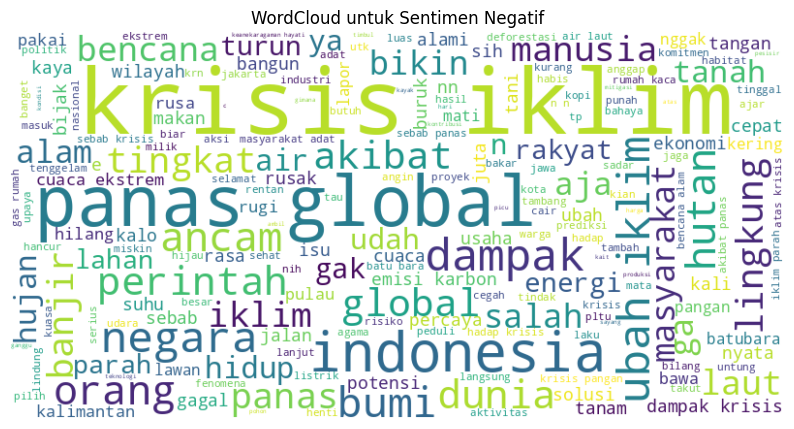

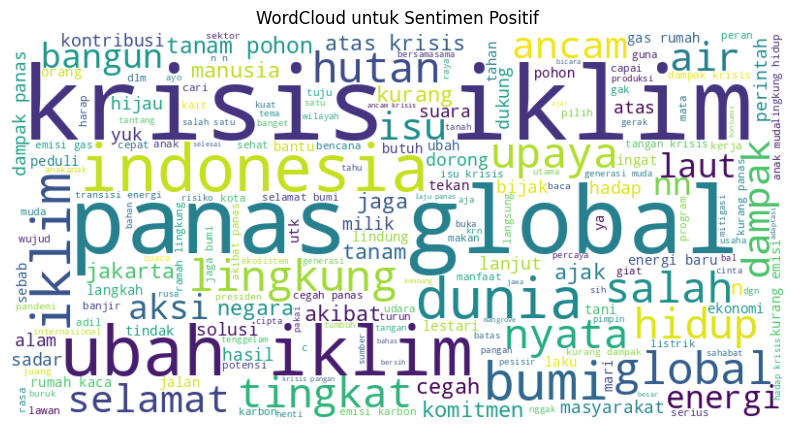

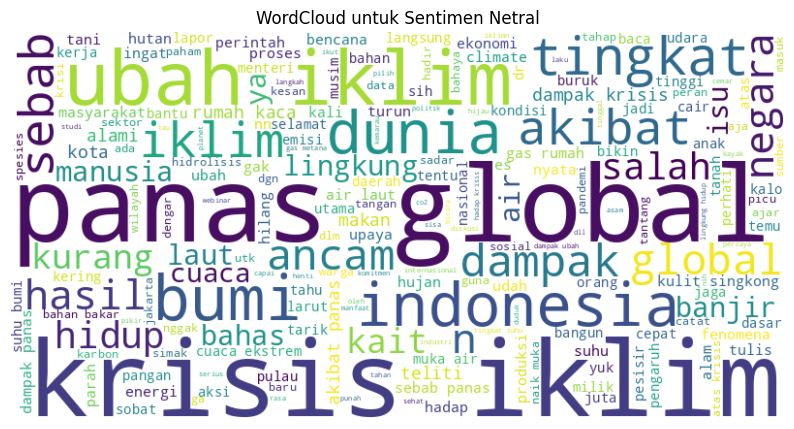

In [ ]:
# 3. WordCloud
def generate_wordcloud(data, sentiment_label, title):
    all_words = ' '.join([text for text in data[data['sentiment'] == sentiment_label]['text']])
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(all_words)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"WordCloud untuk Sentimen {title}")
    plt.show()

# Panggil untuk setiap sentimen
generate_wordcloud(df_data, '0', "Negatif")
generate_wordcloud(df_data, '1', "Positif")
generate_wordcloud(df_data, '2', "Netral")

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi menggunakan Tokenizer untuk analisis panjang teks
df_data['text'] = df_data['text'].astype(str)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_data['text'])

# Menghitung frekuensi kata
word_counts = tokenizer.word_counts
total_words = len(word_counts)
print(f"Total kata unik: {total_words}")

# Menentukan max_features berdasarkan jumlah kata unik
# Misal, kita ingin mempertahankan 80% kata yang paling sering muncul
max_features = int(total_words * 0.8)
print(f"max_features yang diatur untuk TF-IDF: {max_features}")

# Mengubah teks menjadi sequences
sequences = tokenizer.texts_to_sequences(df_data['text'])

# Menentukan max_len berdasarkan panjang teks
text_lengths = [len(seq) for seq in sequences]
max_len = int(np.percentile(text_lengths, 90))  # Misalnya, kita gunakan panjang 90th percentile
print(f"max_len yang diatur untuk padding sequence: {max_len}")

Total kata unik: 8613
max_features yang diatur untuk TF-IDF: 6890
max_len yang diatur untuk padding sequence: 27


In [ ]:
# Proses Tokenisasi, Vektorisasi dan Padding dengan TF-IDF kombinasi N-gram
print("Memulai proses vektorisasi TF-IDF dengan n-gram...")
start_vectorization_time = time.time()
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1, 2), max_df=0.95, min_df=5)
tf_idf = tfidf_vectorizer.fit_transform(df_data['text'])
tf_idf_array = tf_idf.toarray()

# Padding TF-IDF hasil transformasi agar memiliki panjang yang seragam dengan max_len yang ditentukan
# X_tfidf_padded = pad_sequences(tf_idf_array, maxlen=max_len, padding='post')  # Pass X_tfidf_dense instead of X_tfidf

# Prepare labels
y = df_data['sentiment'].astype(int)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(tf_idf_array, y, test_size=0.2, random_state=42, stratify=y)

# Reshape data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

end_vectorization_time = time.time()
vectorization_duration = end_vectorization_time - start_vectorization_time
print(f"Proses vektorisasi TF-IDF dengan n-gram selesai dalam waktu {round(vectorization_duration, 2)} detik...")

Memulai proses vektorisasi TF-IDF dengan n-gram...
Proses vektorisasi TF-IDF dengan n-gram selesai dalam waktu 0.21 detik...


In [ ]:
print(tf_idf.shape)
print(tf_idf_array.shape)

(2276, 1761)
(2276, 1761)


In [ ]:
joblib.dump(tf_idf_array, 'vectorization.pkl')

['vectorization.pkl']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(
<ipython-input-13-edbbf071dfc0>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ngrams), palette="viridis")


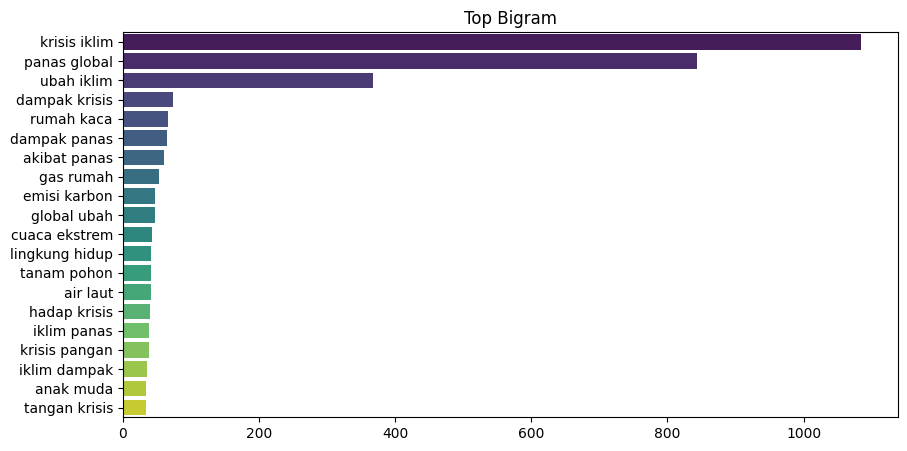

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(
<ipython-input-13-edbbf071dfc0>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(ngrams), palette="viridis")


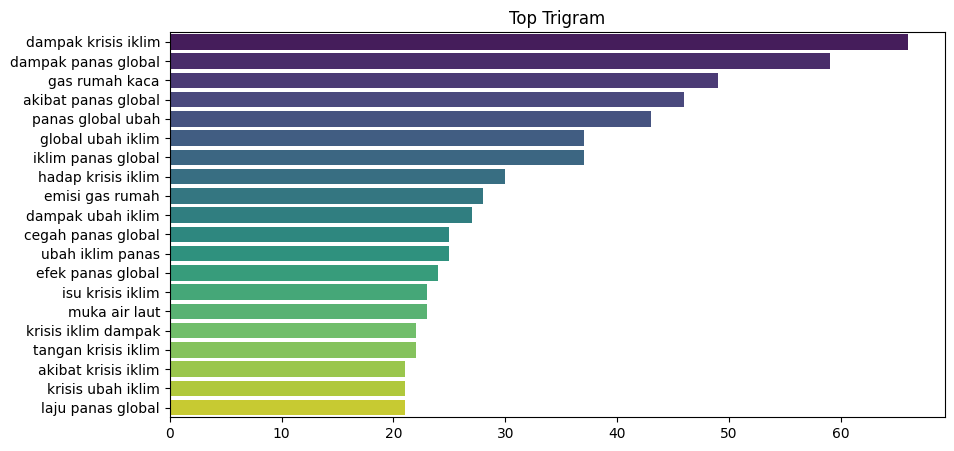

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Fungsi untuk menampilkan bigram atau trigram
def plot_top_ngrams(data, ngram_range=(2, 2), title="Bigrams"):
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=20, stop_words=stopwords_list)
    X = vectorizer.fit_transform(data)
    ngram_counts = X.toarray().sum(axis=0)
    ngrams = vectorizer.get_feature_names_out()
    ngram_freq = dict(zip(ngrams, ngram_counts))
    sorted_ngrams = sorted(ngram_freq.items(), key=lambda x: x[1], reverse=True)
    ngrams, counts = zip(*sorted_ngrams)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(ngrams), palette="viridis")
    plt.title(f"Top {title}")
    plt.show()

# Panggil bigram dan trigram
plot_top_ngrams(df_data['text'], ngram_range=(2, 2), title="Bigram")
plot_top_ngrams(df_data['text'], ngram_range=(3, 3), title="Trigram")

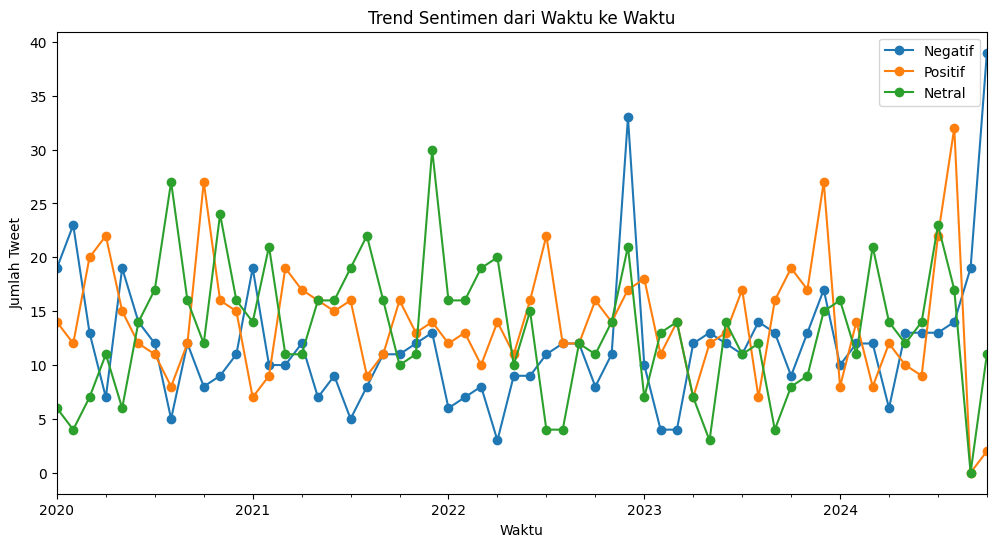

In [ ]:
df_data['date'] = pd.to_datetime(df_data['created_at'])  # Pastikan mengganti 'date_column_name' dengan nama kolom tanggal Anda
sentiment_trend = df_data.groupby([df_data['date'].dt.to_period("M"), 'sentiment']).size().unstack().fillna(0)

sentiment_trend.plot(kind='line', figsize=(12, 6), marker='o')
plt.title("Trend Sentimen dari Waktu ke Waktu")
plt.xlabel("Waktu")
plt.ylabel("Jumlah Tweet")
plt.legend(["Negatif", "Positif", "Netral"])
plt.show()

In [ ]:
print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))

print("\nUkuran X_train:", X_train.shape)
print("Ukuran X_test:", X_test.shape)
print("Ukuran y_train:", y_train.shape)
print("Ukuran y_test:", y_test.shape)

Jumlah data latih: 1820
Jumlah data uji: 456

Ukuran X_train: (1820, 1, 1761)
Ukuran X_test: (456, 1, 1761)
Ukuran y_train: (1820,)
Ukuran y_test: (456,)


In [ ]:
# Build LSTM model without embedding layer
start_train_time = time.time()

print("Building LSTM model with TF-IDF as input...")
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax')
])

# , return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])
# , kernel_regularizer=tf.keras.regularizers.l2(0.001)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Model summary
model.summary()

Building LSTM model with TF-IDF as input...


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 1, 128)              │         967,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,017,771 (3.88 MB)

 Trainable params: 1,017,771 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_test, y_test), verbose=1)
end_train_time = time.time()
training_duration = end_train_time - start_train_time
print(f"Lama waktu training: {round(training_duration, 2)} detik...")

Epoch 1/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3273 - loss: 1.0987 - val_accuracy: 0.3246 - val_loss: 1.0986
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3675 - loss: 1.0985 - val_accuracy: 0.3487 - val_loss: 1.0986
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3809 - loss: 1.0984 - val_accuracy: 0.3553 - val_loss: 1.0985
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3601 - loss: 1.0984 - val_accuracy: 0.3509 - val_loss: 1.0985
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4021 - loss: 1.0983 - val_accuracy: 0.3553 - val_loss: 1.0984
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4057 - loss: 1.0982 - val_accuracy: 0.3618 - val_loss: 1.0983
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4160 - loss: 1.0982 - val_accuracy: 0.3662 - val_loss: 1.0983
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4170 - loss: 1.0981 - val_accuracy: 0.3706 - 

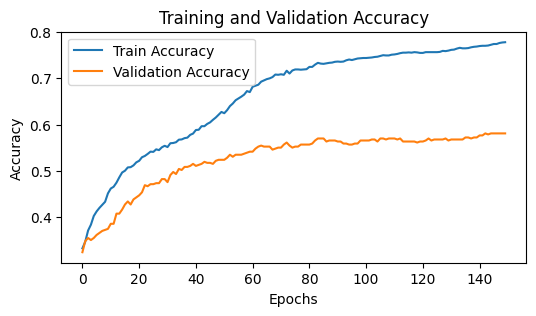

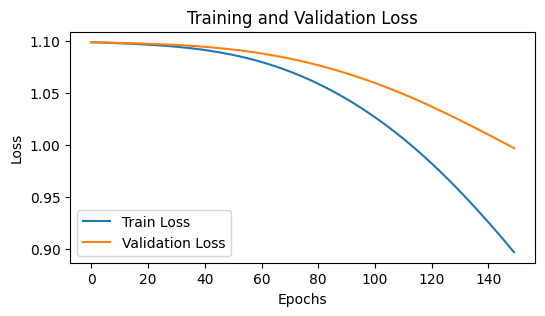

In [ ]:
# Plotting training history
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Pastikan X_test dalam bentuk 3D
# X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Evaluasi Model LSTM
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5859 - loss: 0.9975 
Test Accuracy: 0.5811403393745422


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


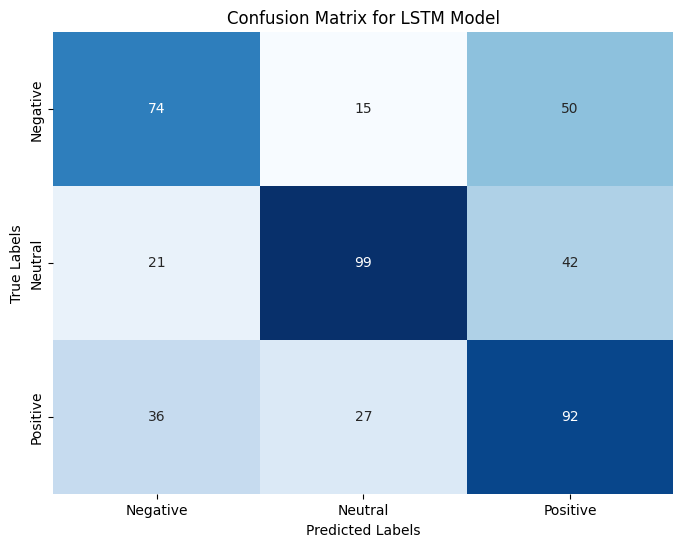

In [ ]:
# Mendapatkan prediksi dari model dalam bentuk 1D
y_pred_lstm = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = y_test if y_test.ndim == 1 else y_test.argmax(axis=-1)

# Menghitung Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_lstm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [ ]:
# Classification Report
print("Classification Report for LSTM:")
print(classification_report(y_test_classes, y_pred_lstm))

Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.56      0.53      0.55       139
           1       0.70      0.61      0.65       162
           2       0.50      0.59      0.54       155

    accuracy                           0.58       456
   macro avg       0.59      0.58      0.58       456
weighted avg       0.59      0.58      0.58       456



In [ ]:
# Dictionary untuk menyimpan model
models = {
    "Naive Bayes": GaussianNB(),
    "Linear SVC": LinearSVC(C=1.0,
                            penalty='l2',
                            max_iter=100,
                            class_weight='balanced',
                            random_state=0),
    "Ensemble Model": AdaBoostClassifier(BaggingClassifier(),
                                         n_estimators=50,
                                         learning_rate=1.0,
                                         random_state=0)
}

# Reshape X_train to 2 dimensions before fitting the models
results = {}
for name, clf in models.items():
    start_time = time.time()

    # Reshape X_train to (num_samples, num_features) if it has 3 dimensions
    if X_train.ndim == 3:
        X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    else:
        X_train_reshaped = X_train

    clf.fit(X_train_reshaped, y_train)

    # Similarly, reshape X_test for prediction
    if X_test.ndim == 3:
        X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
    else:
        X_test_reshaped = X_test

    y_pred = clf.predict(X_test_reshaped)
    duration = time.time() - start_time
    results[name] = {
        "accuracy": np.mean(y_pred == y_test),
        "training_time (s)": duration,
        "precision": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"],
        "recall": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"],
        "f1-score": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
    }

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
# Convert results to DataFrame for better readability
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="accuracy", ascending=False)
round(results_df, 2)

,accuracy,training_time (s),precision,recall,f1-score
Ensemble Model,0.42,212.60,0.42,0.42,0.42
Linear SVC,0.35,0.36,0.35,0.35,0.35
Naive Bayes,0.34,0.48,0.34,0.34,0.33


In [ ]:
# Make predictions
loaded_model = joblib.load('ensemble_model_model.pkl')
predictions = loaded_model.predict(X_test_reshaped)
predictions = (predictions > 0.5).astype(int)

# Display first 10 predictions
print("First 10 Predic :", predictions[:10].flatten())
print("First 10 Actual :", y_test[:10].values)

First 10 Predic : [0 1 1 0 1 0 1 0 0 1]
First 10 Actual : [2 0 2 1 1 1 2 1 0 0]


In [ ]:
import joblib
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Memuat model dan TF-IDF vectorizer yang telah disimpan
loaded_model_name = "lsvc.pkl"  # Model AdaBoost yang telah dilatih dan disimpan
loaded_vectorizer_name = "tfidf_vectorization.pkl"  # TF-IDF vectorizer yang digunakan saat pelatihan

loaded_model = joblib.load(loaded_model_name)
loaded_tfidf_vectorizer = joblib.load(loaded_vectorizer_name)

def text_clean(text):
    # Menghapus emoji dari teks
    text = emoji.replace_emoji(text, replace="")
    # Menghapus mention, hashtag, dan URL
    text = re.sub(r"(@[A-Za-z0-9_]+)|(#\w+)|(\w+:\/\/\S+)", "", text)
    # Menghapus tag retweet
    text = re.sub(r'RT @\w+: ', '', text)
    # Menghapus tanda baca
    text = ''.join([ch for ch in text if ch not in string.punctuation])
    # Mengubah teks menjadi huruf kecil
    text = text.lower()
    # Menghapus teks dalam tanda kurung siku
    text = re.sub(r'\[.*?\]', '', text)
    # Menghapus karakter non-alfabet
    text = re.sub(r'\W', ' ', text)
    # Menghapus baris baru
    text = re.sub(r'\n', ' ', text)
    # Menghapus angka yang berdiri sendiri
    text = re.sub(r'\b\d+\b', '', text)
    # Menghapus spasi berlebih
    text = re.sub(' +', ' ', text)
    return text.strip()

# Fungsi untuk menghapus stopwords
extra_stopwords = ["yg", "amp"]
def remove_stopwords(text, stopwords=stopwords_list+extra_stopwords): # Add stopwords argument with default value
    # Memisahkan teks menjadi kata-kata
    words = text.split()
    # Menghapus kata yang ada dalam daftar stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords] # Use stopwords argument
    # Menggabungkan kembali kata-kata menjadi kalimat
    return ' '.join(filtered_words)

# Fungsi untuk preprocessing teks input
def preprocess_input_text(text):
    text_cleaned = text_clean(text)
    text_no_stopwords = remove_stopwords(text_cleaned)
    # Stemming jika diperlukan
    text_stemmed = ' '.join([stemmer.stem(word) for word in text_no_stopwords.split()])
    return text_stemmed

# Input teks yang akan diprediksi
input_text = "Perubahan iklim adalah masalah global yang memerlukan tindakan segera dari semua negara."
preprocessed_text = preprocess_input_text(input_text)

# Transformasi input teks menggunakan TF-IDF yang telah dimuat
input_vectorized = loaded_tfidf_vectorizer.transform([preprocessed_text])

# Memastikan input_vectorized memiliki jumlah fitur yang sama dengan model
if input_vectorized.shape[1] > loaded_model.n_features_in_:
    input_vectorized = input_vectorized[:, :loaded_model.n_features_in_]

# Prediksi sentimen
prediction = loaded_model.predict(input_vectorized)

# Konversi prediksi ke label sentimen
sentiment_labels = {0: 'Negatif', 1: 'Positif', 2: 'Netral'}
predicted_sentiment = sentiment_labels[prediction[0]]

print(f"Hasil prediksi sentimen untuk input teks adalah: {predicted_sentiment}")

Hasil prediksi sentimen untuk input teks adalah: Negatif


In [ ]:
import joblib
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Memuat model dan TF-IDF vectorizer yang telah disimpan
loaded_model_name = "nb.pkl"  # Model AdaBoost yang telah dilatih dan disimpan
loaded_vectorizer_name = "tfidf_vectorization.pkl"  # TF-IDF vectorizer yang digunakan saat pelatihan

loaded_model = joblib.load(loaded_model_name)
loaded_tfidf_vectorizer = joblib.load(loaded_vectorizer_name)

# Fungsi untuk preprocessing teks input
def preprocess_input_text(text):
    text_cleaned = text_clean(text)
    text_no_stopwords = remove_stopwords(text_cleaned)
    # Stemming jika diperlukan
    text_stemmed = ' '.join([stemmer.stem(word) for word in text_no_stopwords.split()])
    return text_stemmed

# Input teks yang akan diprediksi
input_text = "Perubahan iklim adalah masalah global yang memerlukan tindakan segera dari semua negara."
preprocessed_text = preprocess_input_text(input_text)

# Transformasi input teks menggunakan TF-IDF yang telah dimuat
input_vectorized = loaded_tfidf_vectorizer.transform([preprocessed_text])

# Memastikan input_vectorized memiliki jumlah fitur yang sama dengan model
if input_vectorized.shape[1] > loaded_model.n_features_in_:
    input_vectorized = input_vectorized[:, :loaded_model.n_features_in_]
sd
# Prediksi sentimen
# Convert the sparse matrix to a dense array before prediction
prediction = loaded_model.predict(input_vectorized.toarray()) # Changed line

# Konversi prediksi ke label sentimen
sentiment_labels = {0: 'Negatif', 1: 'Positif', 2: 'Netral'}
predicted_sentiment = sentiment_labels[prediction[0]]

print(f"Hasil prediksi sentimen untuk input teks adalah: {predicted_sentiment}")

Hasil prediksi sentimen untuk input teks adalah: Negatif


In [ ]:
import joblib

# Simpan setiap model yang telah ditraining
for name, clf in models.items():
    model_path = f"{name.replace(' ', '_').lower()}_model.pkl"
    joblib.dump(clf, model_path)
    print(f"Model '{name}' telah disimpan di '{model_path}'")

Model 'Naive Bayes' telah disimpan di 'naive_bayes_model.pkl'
Model 'Linear SVC' telah disimpan di 'linear_svc_model.pkl'
Model 'Ensemble Model' telah disimpan di 'ensemble_model_model.pkl'


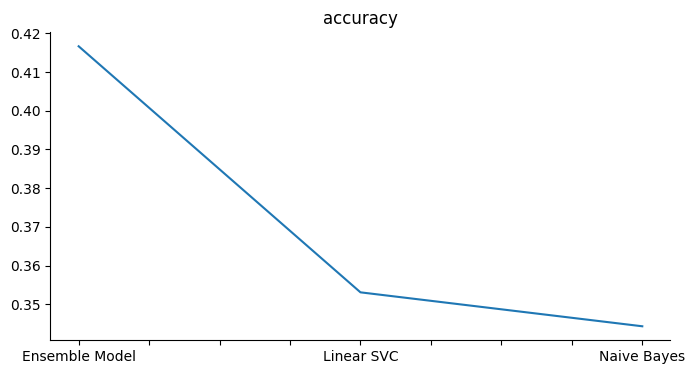

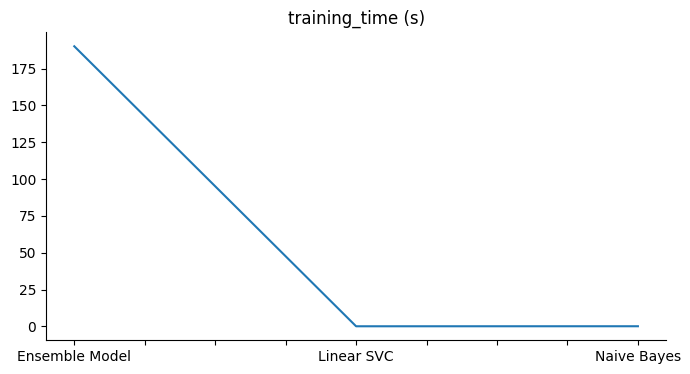

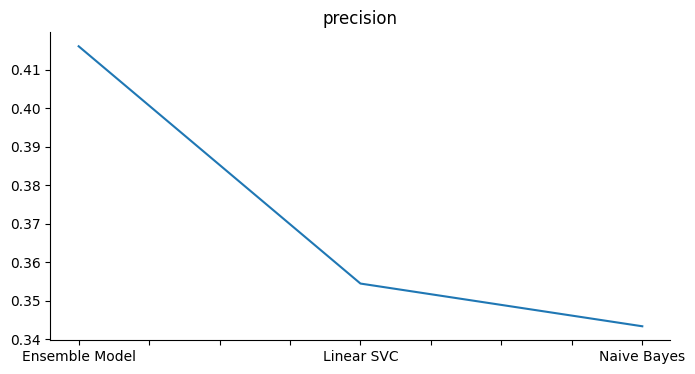

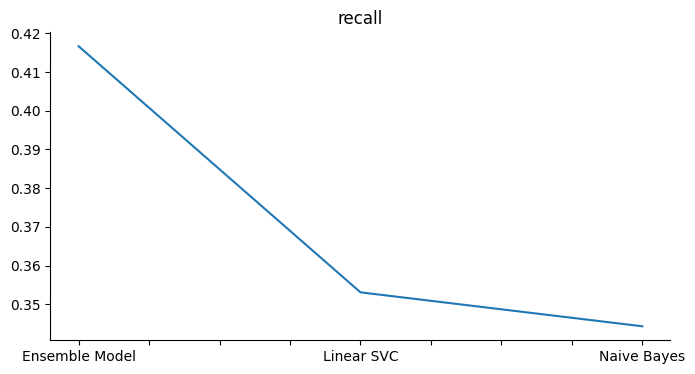

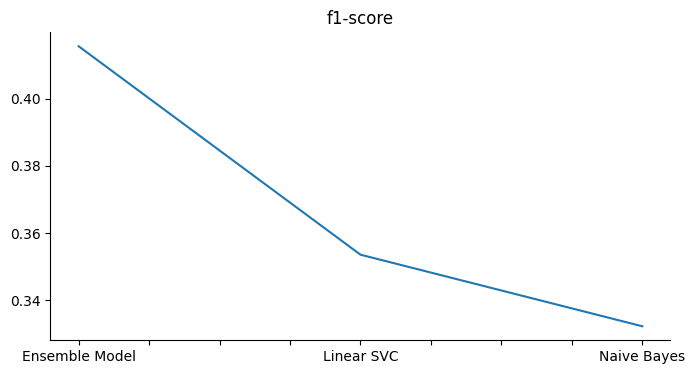

In [ ]:
# @title accuracy, training time (s), precision, recall, dan f1-score
# Plotting the results
results_df['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

results_df['training_time (s)'].plot(kind='line', figsize=(8, 4), title='training_time (s)')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

results_df['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

results_df['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

results_df['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

In [ ]:
# Save the model
model.save('lstm_model.h5')
import joblib
joblib.dump(models['Naive Bayes'], 'nb.pkl')  # Changed clf to models to access the models dictionary
joblib.dump(models['Linear SVC'], 'lsvc.pkl')  # Changed clf to models to access the models dictionary
joblib.dump(models['Ensemble Model'], 'abbg.pkl')  # Changed clf to models to access the models dictionary
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(df_data['text'], 'stemmed_texts.pkl')

['stemmed_texts.pkl']

In [ ]:
# from tensorflow.keras.models import load_model
# # Load the model
# loaded_model = load_model('hoax_detection_model.h5')